# Imports

In [1]:
import datetime
import sklearn.model_selection
import spacy
import requests
import os
from bs4 import BeautifulSoup
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
import itertools
import seaborn as sns
import lightgbm
import tsfresh
from sklearn.preprocessing import MinMaxScaler
import prophet

# Helper Methods

In [2]:
DATA_PATH = "../Data/"
DATA_PATH_NEW = "../Data/Data_new/"
df_article_codes = pd.read_csv("article_codes.csv")
CATEGORIES = ["Games", "Movies", "Music", "Literary"]

In [3]:
def get_fileNames(category: str, path):
    file_names = []
    for files in os.listdir(path + category):
        if files.endswith(".csv"):
            files = files[0:len(files)-4]
            file_names.append(files)
    return file_names

In [4]:
def smape(target, forecast):
    if type(target) == pd.core.frame.DataFrame:
        target = target.values

    denominator = np.abs(target) + np.abs(forecast)
    flag = denominator == 0.

    smape = 2 * np.mean(
        (np.abs(target - forecast) * (1 - flag)) / (denominator + flag)
    )
    return smape

In [8]:
def make_data_new(category, article, days_to_predict):
    df = pd.read_csv(f"{DATA_PATH_NEW}{category}/{article}.csv")
    df.index = df["timestamp"]
    df.drop(['timestamp'], axis=1, inplace=True)
    df.index = pd.to_datetime(df.index, format="%Y%m%d%H")

    #dfN = df[["views"]].copy()
    #df["target"] = df.views.shift(-1)

    # normalization
    scaler = MinMaxScaler(feature_range=(1, 5))
    data = np.array(df["views"])
    data = data.reshape(len(data), 1)
    scaler = scaler.fit(data)
    data = scaler.transform(data)
    df["views"] = data

    df.dropna(inplace=True)
    df = create_features(df)

    #df = df.loc[(df.index >= '2015.01.01') & (df.index <= "2021.01.01")]
    dfNeu = df.tail(days_to_predict)
    df = df.head(len(df) - days_to_predict)

    return df, dfNeu

def make_data(category, article, days_to_predict):
    df = pd.read_csv(f"{DATA_PATH}{category}/{article}.csv")
    code = df_article_codes.loc[df_article_codes["article"] == df["article"][0].replace("_", " ")]["code"]
    df = df.drop(["project", "granularity", "access", "agent", "article"], axis=1)
    df["article"] = list(code)[0]

    df.index = df["timestamp"]
    df.index = pd.to_datetime(df.index)
    df.drop(['timestamp'], axis=1, inplace=True)

    # normalization
    scaler = MinMaxScaler(feature_range=(1, 5))
    data = np.array(df["views"])
    data = data.reshape(len(data), 1)
    scaler = scaler.fit(data)
    data = scaler.transform(data)
    df["views"] = data

    df.dropna(inplace=True)
    df = create_features(df)

    #df = df.loc[(df.index >= '2015.01.01') & (df.index <= "2021.01.01")]
    dfNeu = df.tail(days_to_predict)
    df = df.head(len(df) - days_to_predict)

    return df, dfNeu
make_data("Games", "Advance Wars", 14)[0]

,views,article,dayofweek,month,quarter,dayofyear,year,avg,t-1,t-2,t-3,t-4,t-5,t-6,t-7
timestamp,,,,,,,,,,,,,,,
2015-07-01,1.086553,0,2,7,3,182,2015,1.086553,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-02,1.102897,0,3,7,3,183,2015,1.094725,1.086553,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-03,1.089896,0,4,7,3,184,2015,1.093115,1.102897,1.086553,NaN,NaN,NaN,NaN,NaN
2015-07-04,1.065750,0,5,7,3,185,2015,1.086274,1.089896,1.102897,1.086553,NaN,NaN,NaN,NaN
2015-07-05,1.061664,0,6,7,3,186,2015,1.081352,1.065750,1.089896,1.102897,1.086553,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-14,1.027117,0,1,12,4,348,2021,1.072257,1.019688,1.039004,1.047548,1.025632,1.021545,1.034547,1.036033
2021-12-15,1.046434,0,2,12,4,349,2021,1.072247,1.027117,1.019688,1.039004,1.047548,1.025632,1.021545,1.034547
2021-12-16,1.026374,0,3,12,4,350,2021,1.072227,1.046434,1.027117,1.019688,1.039004,1.047548,1.025632,1.021545


In [ ]:
counter = 0
files = []
code = []
for category in ["Games", "Music", "Movies", "Literary"]:
    for file in get_fileNames(category, DATA_PATH):
        files.append(file)
        code.append(counter)
        counter += 1
df = pd.DataFrame({"article": files, "code": code})
df.to_csv("article_codes.csv")

# Features

In [7]:
def create_features(df):
    if isinstance(df, tuple):
        df = df[0]
    df = df.copy()
    df["dayofweek"] = df.index.dayofweek
    df["month"] = df.index.month
    df["quarter"] = df.index.quarter
    df["dayofyear"] = df.index.dayofyear
    df["year"] = df.index.year
    avg = []
    for i in range(1, len(df["views"]) + 1):
        avg.append(df["views"][0:i].mean())
    df["avg"] = avg
    for i in range(1, 8):
        df[f"t-{i}"] = df["views"].shift(i).ffill()
    return df

FEATURES = ["dayofweek", "month", "quarter", "dayofyear", "year", "avg", "t-1", "t-2", "t-3", "t-4", "t-5", "t-6", "t-7", "article"]
TARGET = "views"

# Preprocess Data

In [ ]:
for category in CATEGORIES:
    pd.concat(make_data(category, file, 14)[0] for file in get_fileNames(category, DATA_PATH)).to_csv(f"data_{category}_small.csv")

# XGBoost

In [ ]:
%%time

def train_xg(categories, model):
    df_all = pd.concat([pd.read_csv(f"data_{category}_small.csv") for category in categories])
    print(len(df_all))
    train_data, test_data = sklearn.model_selection.train_test_split(df_all, test_size=0.3, random_state=69)

    X_train = train_data[FEATURES]
    y_train = train_data[TARGET]
    X_test = test_data[FEATURES]
    y_test = test_data[TARGET]

    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=1000)

param = {
    'early_stopping_rounds': 50,
    'disable_default_eval_metric': True,
    'eval_metric': smape,
    'lambda': 8.946094465067073,
     'alpha': 1.8028192346084864,
     'colsample_bytree': 0.996910386965166,
     'subsample': 0.902507239766619,
     'learning_rate': 0.005301889499373679,
     'max_depth': 19,
     'min_child_weight': 235,
     'n_estimators': 10000,
     'tree_method': 'gpu_hist'
}

xgmodel = xgb.XGBRegressor(**param)
train_xg(["Games", "Music", "Movies", "Literary"], xgmodel)

In [ ]:
xgmodel.save_model("xgboost_small")

In [ ]:
def eval_xg(xgmodel):
    smapes = []
    for category in CATEGORIES:
        for file in get_fileNames(category, DATA_PATH):
            predictions = []
            old, df = make_data(category, file, 14)
            indeces = df.index
            df["t-1"][1:] = None
            df["avg"][1:] = None
            avgs = [df["avg"][indeces[0]]] * len(old)
            for i in range(0, 13):
                tmp = pd.DataFrame(df[FEATURES].loc[indeces[i]]).T
                pred = xgmodel.predict(tmp)[0]
                predictions.append(pred)
                avgs.append(pred)

                df.loc[indeces[i + 1], 'avg'] = (sum(avgs) / len(avgs))
                for j in range(1, 8):
                    if i + j < len(indeces):
                        df.loc[indeces[i + j], f't-{j}'] = pred
            tmp = pd.DataFrame(df[FEATURES].loc[indeces[13]]).T
            pred = xgmodel.predict(tmp)[0]
            predictions.append(pred)
            df["predictions"] = predictions

            smapes.append(smape(df["views"], df["predictions"]))
    return smapes

In [ ]:
import optuna

category = ["Music", "Games", "Literary", "Movies"]
data = []
for i in category:
    for file in get_fileNames(i):
        df, df_new_data = make_data(i, file, 14)
        data.append(df)
data = pd.concat(data)

def objective(trial,data=data):

    train, test = sklearn.model_selection.train_test_split(data, test_size=0.3,random_state=42)

    train_x = train[FEATURES]
    train_y = train[TARGET]

    test_x = test[FEATURES]
    test_y = test[TARGET]

    param = {
        'eval_metric': smape,
        'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 10000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
        'random_state': trial.suggest_categorical('random_state', [2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = xgb.XGBRegressor(**param)

    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=50,verbose=1000)

    preds = model.predict(test_x)

    loss = smape(test_y, preds)

    return loss
'''
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
'''

In [ ]:
study.trials_dataframe()

In [ ]:
Best_trial = study.best_trial.params
Best_trial["n_estimators"], Best_trial["tree_method"] = 10000, 'gpu_hist'
Best_trial

In [ ]:
Best_trial = study.best_trial.params
Best_trial["n_estimators"], Best_trial["tree_method"] = 10000, 'gpu_hist'
Best_trial

# Light GBM

In [ ]:
%%time

param = {'reg_alpha': 5.780930573640521,
         'reg_lambda': 3.73323142532226,
         'colsample_bytree': 0.8075916654628037,
         'subsample': 0.9116907631660646,
         'learning_rate': 0.013939335540405618,
         'max_depth': 161,
         'num_leaves': 312,
         'min_child_samples': 42,
         'min_data_per_groups': 58}

lgbm_model = lightgbm.LGBMRegressor(n_estimators=5000, **param, first_metric_only=True, metric="smape")

def smape2(target, forecast):
    return "smape", smape(np.array(target), np.array(forecast)), False

def train_lgbm(categories, model):
    df_all = pd.concat([pd.read_csv(f"data_{category}_small.csv") for category in categories])
    print(len(df_all))
    train_data, test_data = sklearn.model_selection.train_test_split(df_all, test_size=0.3, random_state=69)

    X_train = train_data[FEATURES]
    y_train = train_data[TARGET]
    X_test = test_data[FEATURES]
    y_test = test_data[TARGET]

    model.fit(X_train, y_train, eval_metric=smape2, eval_set=[(X_test, y_test)],verbose=500 ,early_stopping_rounds=50)
train_lgbm(["Games", "Music", "Movies", "Literary"], lgbm_model)

In [ ]:
def eval_lgbm(model):
    smapes = []
    for category in CATEGORIES:
        for file in get_fileNames(category, DATA_PATH):
            predictions = []
            old, df = make_data(category, file, 14)
            indeces = df.index
            df["t-1"][1:] = None
            df["avg"][1:] = None
            avgs = [df["avg"][indeces[0]]] * len(old)
            for i in range(0, 13):
                tmp = pd.DataFrame(df[FEATURES].loc[indeces[i]]).T
                pred = model.predict(tmp)[0]
                predictions.append(pred)
                avgs.append(pred)
                df.loc[indeces[i + 1], 'avg'] = (sum(avgs) / len(avgs))
                for j in range(1, 8):
                    if i + j < len(indeces):
                        df.loc[indeces[i + j], f't-{j}'] = pred
            tmp = pd.DataFrame(df[FEATURES].loc[indeces[13]]).T
            pred = model.predict(tmp)[0]
            predictions.append(pred)
            df["predictions"] = predictions
            smapes.append(smape(df["views"], df["predictions"]))
    return smapes

#smapes = eval_lgbm(lgbm_model)

In [ ]:
lgbm_model.booster_.save_model("lgbm_small")

In [ ]:
import optuna

data = pd.concat([pd.read_csv(f"data_{i}_small.csv") for i in CATEGORIES])

def objective(trial,data=data):

    train, test = sklearn.model_selection.train_test_split(data, test_size=0.3,random_state=42)

    train_x = train[FEATURES]
    train_y = train[TARGET]

    test_x = test[FEATURES]
    test_y = test[TARGET]

    param = {
        'metric': 'smape',
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.02),
        'max_depth': trial.suggest_int('max_depth', 10, 200),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }

    model = lightgbm.LGBMRegressor(**param)

    model.fit(train_x, train_y, eval_metric=smape2, eval_set=[(test_x, test_y)], early_stopping_rounds=50, verbose=1000)

    preds = model.predict(test_x)

    loss = smape(test_y, preds)

    return loss

'''
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
'''

In [ ]:
study.best_trial.params

In [ ]:
study.trials_dataframe()

# Prophet

In [ ]:
%%time

prophet_loss = []

for category in CATEGORIES:
    for file in get_fileNames(category, DATA_PATH):
        data, eval = make_data(category, file, 14)
        data.rename(columns={"views": "y"}, inplace=True)
        eval.rename(columns={"views": "y"}, inplace=True)
        data["ds"] = data.index
        eval["ds"] = eval.index

        m = prophet.Prophet()
        m.fit(data)

        future = m.make_future_dataframe(periods=14)
        future = future.tail(14)

        forecast = m.predict(future)
        forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

        #fig1 = m.plot(forecast)
        #fig2 = m.plot_components(forecast)

        prophet_loss.append(smape(np.array(eval["y"]), np.array(forecast["yhat"])))

# XGBoost vs Light GBM

In [ ]:
loss_xg = eval_xg(xgmodel)
loss_lgbm = eval_lgbm(lgbm_model)

CPU times: total: 31.2 ms
Wall time: 28 ms


<AxesSubplot: >

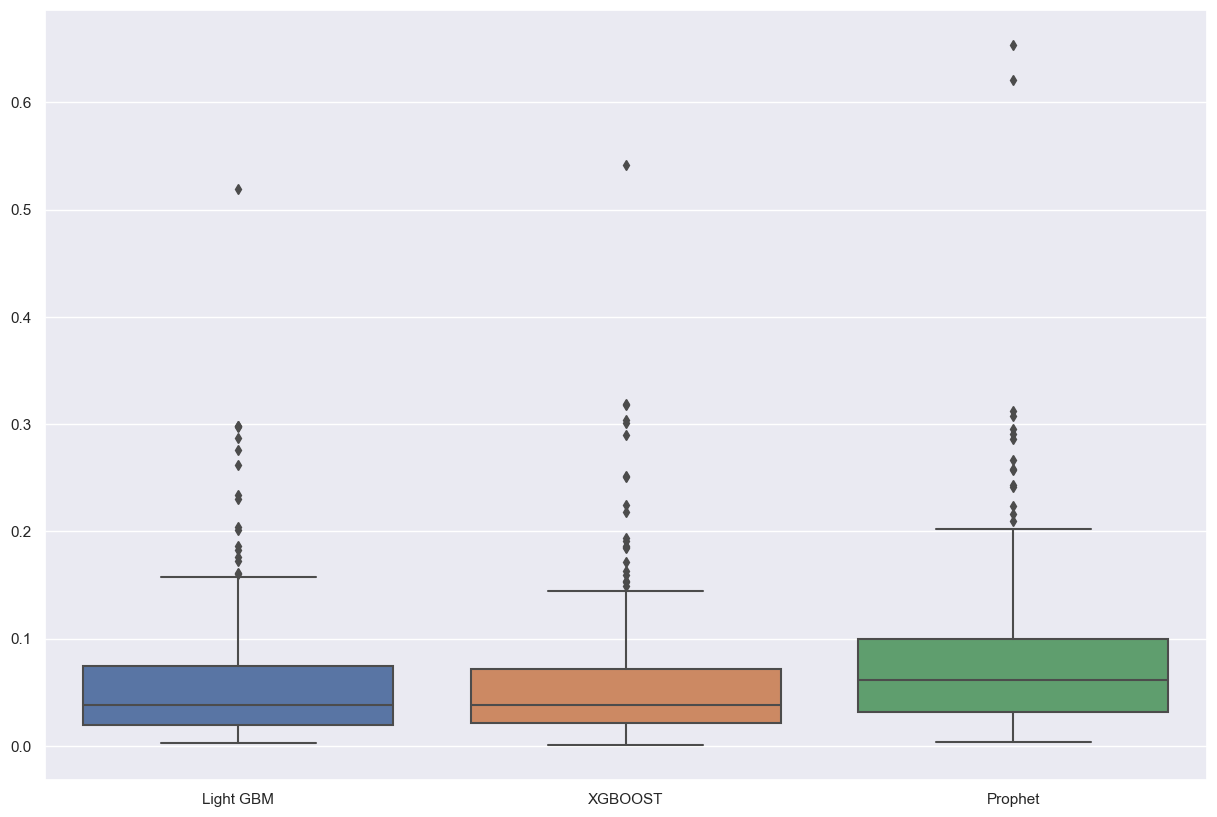

In [101]:
%%time
df = pd.DataFrame({
    "Light GBM": loss_lgbm,
    "XGBOOST": loss_xg,
    "Prophet": prophet_loss,
})

sns.set(rc={'figure.figsize':(15,10)})
sns.boxplot(data=df)

In [102]:
print(f"Light GBM: {df['Light GBM'].mean()}")
print(f"XGBoost: {df['XGBOOST'].mean()}")
print(f"Prophet: {pd.DataFrame(prophet_loss).mean()[0]}")

Light GBM: 0.05804541671516902
XGBoost: 0.05911126435348576
Prophet: 0.08117801092656696


Text(0.5, 1.0, 'XGBoost')

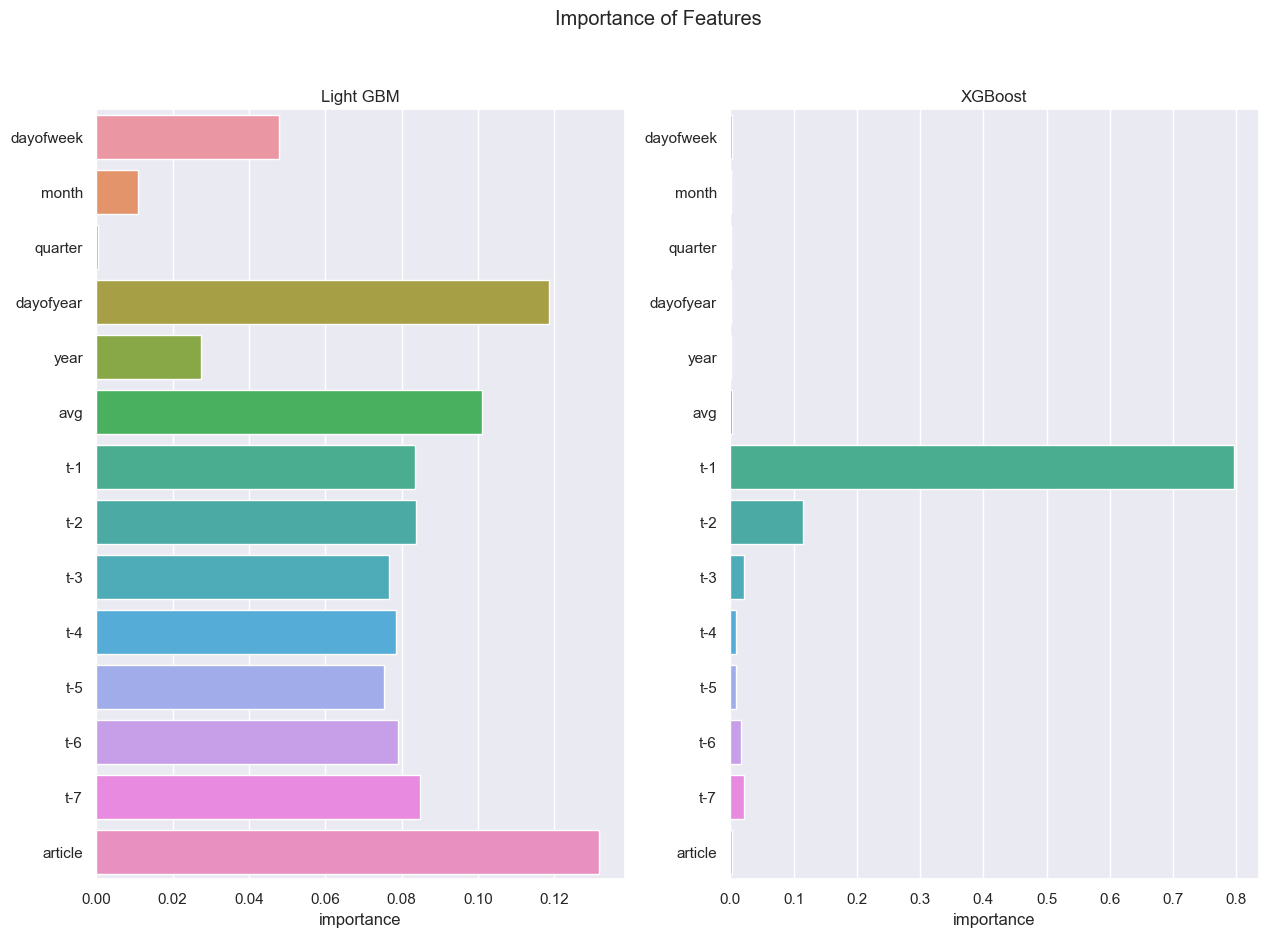

In [103]:
df_lgbm = pd.DataFrame(data=lgbm_model.feature_importances_,
                  index=lgbm_model.feature_name_,
                  columns=["importance"])

df_xg = pd.DataFrame(data=xgmodel.feature_importances_,
                  index=xgmodel.feature_names_in_,
                  columns=["importance"])

x = sum(df_lgbm["importance"])
df_lgbm /= x

fig, axes = plt.subplots(1, 2)
fig.suptitle("Importance of Features")

sns.barplot(ax=axes[0], x=df_lgbm["importance"], y=df_lgbm.index)
axes[0].set_title("Light GBM")

sns.barplot(ax=axes[1], x=df_xg["importance"], y=df_xg.index)
axes[1].set_title("XGBoost")

In [ ]:
print(f"Music: {len(get_fileNames('Music', DATA_PATH))}")
print(f"Movies: {len(get_fileNames('Movies', DATA_PATH))}")
print(f"Games: {len(get_fileNames('Games', DATA_PATH))}")
print(f"Literary: {len(get_fileNames('Literary', DATA_PATH))}")

,timestamp,views,article,dayofweek,month,quarter,dayofyear,year,avg,t-1,t-2,t-3,t-4,t-5,t-6,t-7
0,2015-07-01,1.086553,0,2,7,3,182,2015,1.086553,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-07-02,1.102897,0,3,7,3,183,2015,1.094725,1.086553,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-07-03,1.089896,0,4,7,3,184,2015,1.093115,1.102897,1.086553,NaN,NaN,NaN,NaN,NaN
3,2015-07-04,1.065750,0,5,7,3,185,2015,1.086274,1.089896,1.102897,1.086553,NaN,NaN,NaN,NaN
4,2015-07-05,1.061664,0,6,7,3,186,2015,1.081352,1.065750,1.089896,1.102897,1.086553,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169212,2021-12-14,1.443209,306,1,12,4,348,2021,1.402691,1.441620,1.268467,1.212867,1.401906,1.516283,1.563940,2.016680
169213,2021-12-15,1.430500,306,2,12,4,349,2021,1.402703,1.443209,1.441620,1.268467,1.212867,1.401906,1.516283,1.563940
169214,2021-12-16,1.813344,306,3,12,4,350,2021,1.402877,1.430500,1.443209,1.441620,1.268467,1.212867,1.401906,1.516283
169215,2021-12-17,1.277998,306,4,12,4,351,2021,1.402824,1.813344,1.430500,1.443209,1.441620,1.268467,1.212867,1.401906


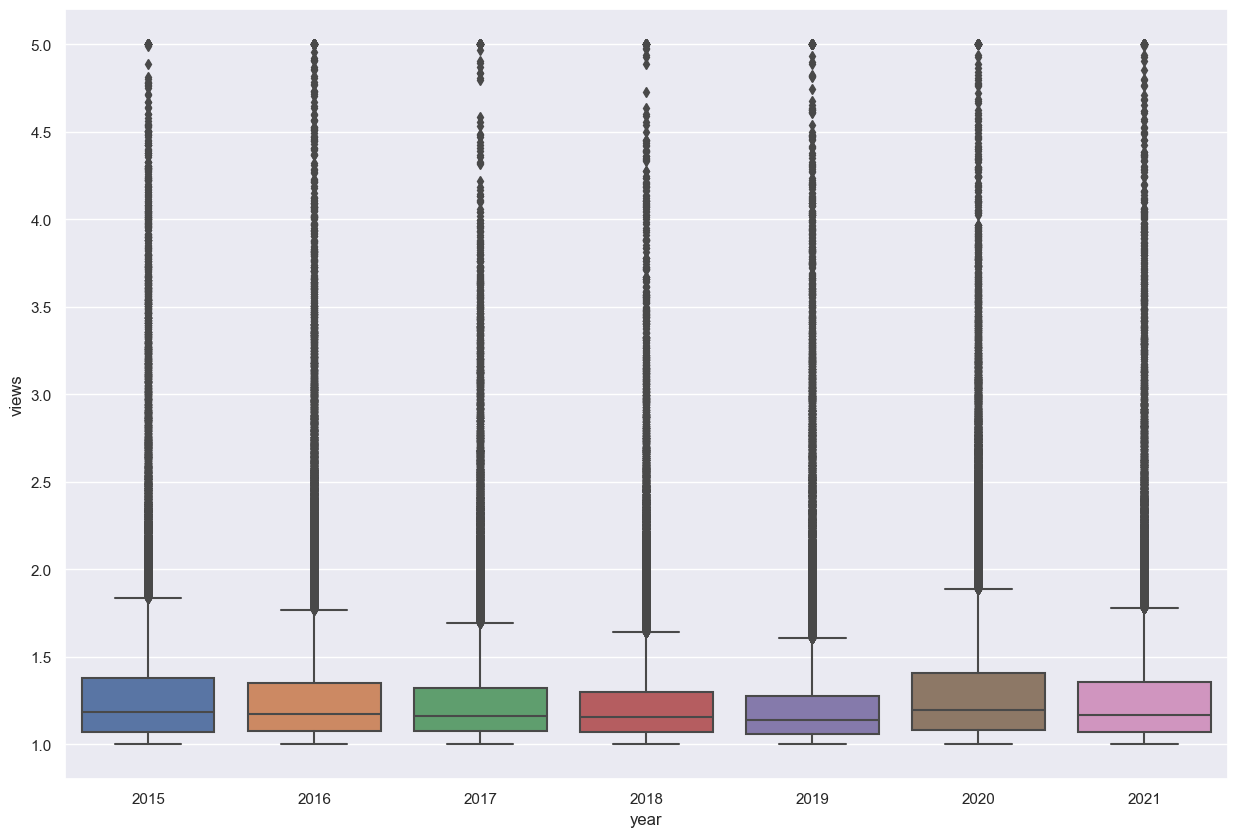

In [105]:
dfs = []
df = pd.concat([pd.read_csv(f"data_{i}_small.csv") for i in CATEGORIES])

sns.set(rc={'figure.figsize':(15,10)})
sns.boxplot(data=df, x="year", y="views")
df